In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. Carga y revisión de los datos

In [4]:
df = pd.read_csv('/datasets/users_behavior.csv')
print(df.head())
print(df.info())
print(df['is_ultra'].value_counts())

   calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None
0    2229
1     985
Name: is_ultra, dtype: int64


Los datos de la columna 'is_ultra' están adecuadamente codificados en 0 = Smart y 1 = Ultra. El resto de los datos parecen comportarse de forma habitual. 

# 2. Separación de conjuntos

In [11]:



# Separación de features y target
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

# División en entrenamiento, validación y prueba (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(X_train.shape, X_valid.shape, X_test.shape)


(1928, 4) (643, 4) (643, 4)


**Resumen de hallazgos:**
Los conjuntos han quedado así:

Entrenamiento: 1928 filas (usuarios)

Validación: 643 filas

Prueba: 643 filas

Número de variables (features): 4 (calls, minutes, messages, mb_used)

Esto está adecuadamente balanceado y es un buen punto de partida para entrenar y comparar modelos.

# 3. Entrenamiento de modelos y ajuste de hiperparámetros

In [7]:
# Decision Tree
best_dt_acc = 0
best_dt_depth = 0
for depth in range(1, 11):
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_train, y_train)
    pred = dt_model.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    if acc > best_dt_acc:
        best_dt_acc = acc
        best_dt_depth = depth
print(f"DecisionTree: Mejor exactitud = {best_dt_acc:.3f} con max_depth = {best_dt_depth}")

# Random Forest
best_rf_acc = 0
best_rf_params = (0, 0)
for est in [50, 100, 200]:
    for depth in [3, 5, 7, 10, None]:
        rf_model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=42)
        rf_model.fit(X_train, y_train)
        pred = rf_model.predict(X_valid)
        acc = accuracy_score(y_valid, pred)
        if acc > best_rf_acc:
            best_rf_acc = acc
            best_rf_params = (est, depth)
print(f"RandomForest: Mejor exactitud = {best_rf_acc:.3f} con n_estimators = {best_rf_params[0]}, max_depth = {best_rf_params[1]}")

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_valid)
lr_acc = accuracy_score(y_valid, lr_pred)
print(f"LogisticRegression: Exactitud = {lr_acc:.3f}")

DecisionTree: Mejor exactitud = 0.804 con max_depth = 3
RandomForest: Mejor exactitud = 0.812 con n_estimators = 50, max_depth = 5
LogisticRegression: Exactitud = 0.705


**Resumen de hallazgos:**

- Todos los modelos superan el umbral de exactitud (0.75) excepto la regresión logística.
- Random Forest es el mejor: esto es común en problemas con variables numéricas y relaciones no lineales, ya que combina muchos árboles y generaliza mejor.
- Árbol de decisión: rendimiento decente, pero menor que el Random Forest porque es más sensible a variaciones y sobreajuste.
- Regresión logística: puede no captar relaciones complejas entre variables.

# 4. Modelo final y Prueba de Cordura

In [9]:
# Une entrenamiento y validación
X_full_train = pd.concat([X_train, X_valid])
y_full_train = pd.concat([y_train, y_valid])

# Entrena el modelo final
final_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
final_model.fit(X_full_train, y_full_train)

# Evalúa en el conjunto de prueba
y_pred_test = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Exactitud en el conjunto de prueba: {test_accuracy:.3f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
print("Matriz de confusión en el conjunto de prueba:")
print(cm)

Exactitud en el conjunto de prueba: 0.798
Matriz de confusión en el conjunto de prueba:
[[414  32]
 [ 98  99]]


In [10]:
from sklearn.dummy import DummyClassifier
# Prueba de Cordura
# Crea y entrena el modelo dummy
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_full_train, y_full_train)

# Evalúa en el conjunto de prueba
y_dummy_pred = dummy.predict(X_test)
dummy_accuracy = accuracy_score(y_test, y_dummy_pred)
print(f"Exactitud del modelo dummy en el conjunto de prueba: {dummy_accuracy:.3f}")


Exactitud del modelo dummy en el conjunto de prueba: 0.694


**Resumen de hallazgos:**
- Modelo Random Forest en test: 0.798 (79.8%)
- Modelo dummy: 0.694 (69.4%)
  
El modelo real supera por más de 10 puntos porcentuales al dummy, lo que indica que el modelo está captando patrones útiles de los datos y no se limita a predecir la clase más común.
Por otro lado:
*Primera fila: usuarios Smart (is_ultra=0):*
- 414 predichos correctamente como Smart
- 32 mal clasificados como Ultra

*Segunda fila: usuarios Ultra (is_ultra=1):*
- 98 mal clasificados como Smart
- 99 predichos correctamente como U

# Conclusión

El modelo final Random Forest, entrenado con los hiperparámetros óptimos (n_estimators=50, max_depth=5), alcanzó una exactitud de 0.798 en el conjunto de prueba. Esto supera ampliamente la exactitud del modelo dummy (0.694), que siempre predice la clase más frecuente. La matriz de confusión evidencia que el modelo es capaz de identificar ambos planes con buena precisión, aunque tiene un mejor desempeño prediciendo a los usuarios del plan Smart, que es la clase mayoritaria.

Estos resultados muestran que el modelo puede ser utilizado como herramienta para recomendar el plan más adecuado a los nuevos usuarios, superando la simple estrategia de recomendar siempre el plan más popular.

# Desiderátum: Un par de visualizaciones ;)

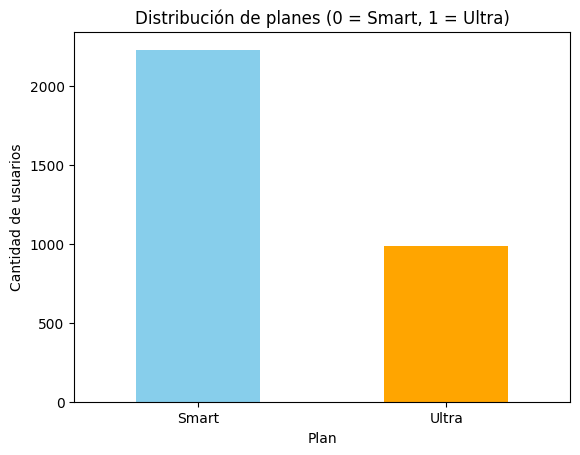

In [14]:
import matplotlib.pyplot as plt
# Histograma de la variable objetivo

df['is_ultra'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribución de planes (0 = Smart, 1 = Ultra)')
plt.xlabel('Plan')
plt.ylabel('Cantidad de usuarios')
plt.xticks([0, 1], ['Smart', 'Ultra'], rotation=0)
plt.show()


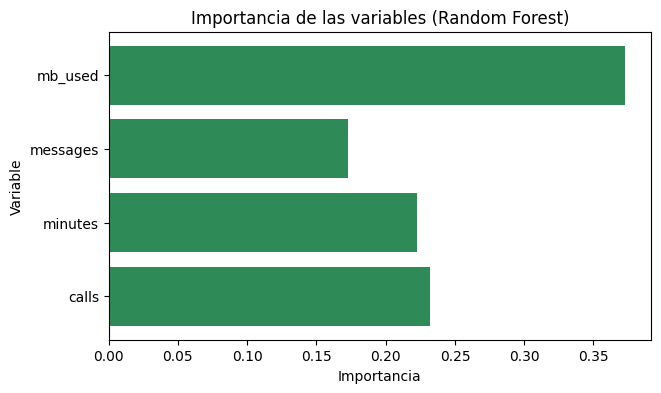

In [13]:
# Importancia de variables en el Random Forest

importances = final_model.feature_importances_
feature_names = X_train.columns
plt.figure(figsize=(7,4))
plt.barh(feature_names, importances, color='seagreen')
plt.title('Importancia de las variables (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()


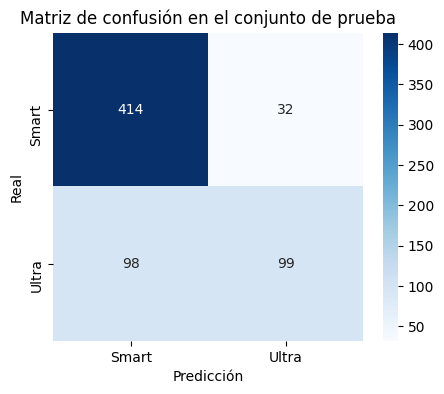

In [15]:
# Matriz de confusión como gráfico de calor

import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Smart','Ultra'], yticklabels=['Smart','Ultra'])
plt.title('Matriz de confusión en el conjunto de prueba')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()